# Predicting Apartment Rental Prices with Random Forest Regression

## Data Extraction and Train-Test Split

This section covers the process of data extraction from an Excel file, where processed and clean data for apartments rental prices are stored, and the preparation of training and testing datasets for model training and evaluation.

### Steps:

1. **Library Imports**: We import the necessary libraries, including pandas for data manipulation, numpy for numerical operations, RandomForestRegressor for model training, train_test_split for splitting data into training and testing sets, and RandomizedSearchCV for hyperparameter tuning.

2. **Data Loading**: We load the dataset from an Excel file which stores processed and clean data (`Processed data combined.xlsx`) into a pandas DataFrame (`data`).

3. **Feature and Target Variable Separation**: We separate the features (`x`) from the target variable `'price'` (`y`) in the dataset.

4. **Train-Test Split**: We split the dataset into training and testing sets using the train_test_split function. The training set comprises 75% of the data (`x_train` and `y_train`), while the testing set comprises the remaining 25% (`x_test` and `y_test`). We specify a random seed (`random_state`) to ensure reproducibility.

5. **Data Shape Check**: We print the shapes of the training and testing datasets to verify the size of each set.

By splitting the data into training and testing sets, we ensure that our model is trained on a portion of the data and evaluated on unseen data, facilitating unbiased performance assessment.

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

data = pd.read_excel('Excel_files\\Processed data combined.xlsx')
x = data.drop('price', axis=1)
y = data.price
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, test_size=0.25, random_state=6)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(495, 20)
(166, 20)
(495,)
(166,)


## Random Forest Hyperparameter Grid

In this code block, we define a grid of hyperparameters for tuning a Random Forest model using cross-validation or grid search.

### Parameters:

- **n_estimators**: Number of trees in the forest. We generate a list of evenly spaced values ranging from 200 to 2000 with 10 intervals.
  
- **max_features**: Number of features to consider at each split. Here, we specify two options: 'log2' and 'sqrt'.
  
- **max_depth**: Maximum number of levels in each decision tree. We create a list of evenly spaced values from 10 to 110 with 11 intervals, and 'None' is added to allow unlimited depth.
  
- **min_samples_split**: Minimum number of samples required to split an internal node. We define three options: 2, 5, and 10.
  
- **min_samples_leaf**: Minimum number of samples required to be at a leaf node. We specify three options: 1, 2, and 4.
  
- **bootstrap**: Method for sampling data points (with or without replacement) when building trees. We include both True and False options.

### Random Grid Creation:

We create a dictionary called `random_grid` containing all the hyperparameter options defined above. This grid will be used for randomized search or grid search to find the best combination of hyperparameters for our Random Forest model.


In [3]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## Model Creation with RandomizedSearchCV

In this section, we utilize RandomizedSearchCV to find the best hyperparameters for our Random Forest model and evaluate its performance using cross-validation.

### Steps:

1. **Random Forest Model Initialization**: We initialize a Random Forest regressor (`rf_model`) with default parameters.

2. **Randomized Search**: We perform randomized search over the hyperparameter grid (`random_grid`) using RandomizedSearchCV. This involves iterating over a predefined number of combinations (`n_iter`) and evaluating them using cross-validation (`cv`). The `param_distributions` parameter specifies the hyperparameter grid, and we specify additional parameters such as verbosity (`verbose`), random state (`random_state`), and parallelism (`n_jobs`).

3. **Model Fitting**: We fit the RandomizedSearchCV object (`rf_random`) to the training data (`x_train` and `y_train`). This process involves training multiple Random Forest models with different hyperparameter combinations and selecting the best performing model based on the specified scoring metric.

4. **Best Parameters and Score**: After fitting the RandomizedSearchCV object, we retrieve the best hyperparameters (`best_params`) and the corresponding best score (`best_score`) achieved during cross-validation.

### Results:

- **Best Parameters**: The hyperparameters that yielded the highest cross-validation score.
  
- **Best Score**: The cross-validation score (negative mean squared error) achieved by the model with the best parameters.

By leveraging RandomizedSearchCV, we efficiently search through a large hyperparameter space to find optimal settings for our Random Forest model, improving its predictive performance.

In [4]:
rf_model = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(x_train, y_train)
best_params = rf_random.best_params_
best_score = rf_random.best_score_
print("Best Parameters:", best_params)
print("Best Score (Negative Mean Squared Error):", best_score)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best Score (Negative Mean Squared Error): 0.5187919883697215


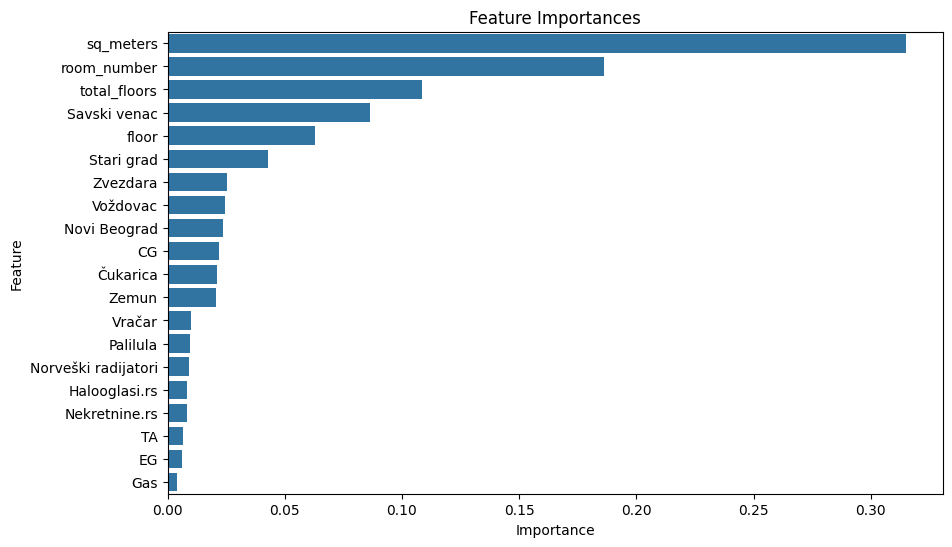

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Train the final model with the best parameters
rf_final = RandomForestRegressor(**best_params)
rf_final.fit(x_train, y_train)

# Feature importance
feature_importances = rf_final.feature_importances_
features = x.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

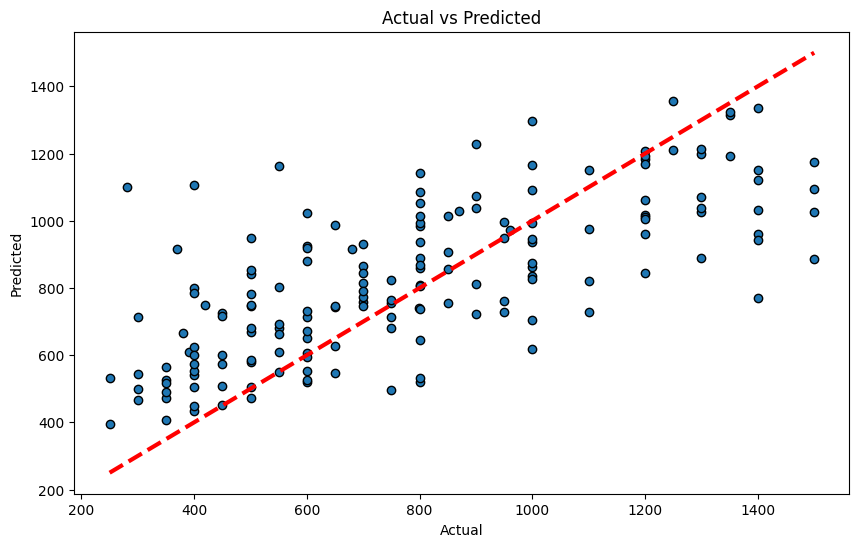

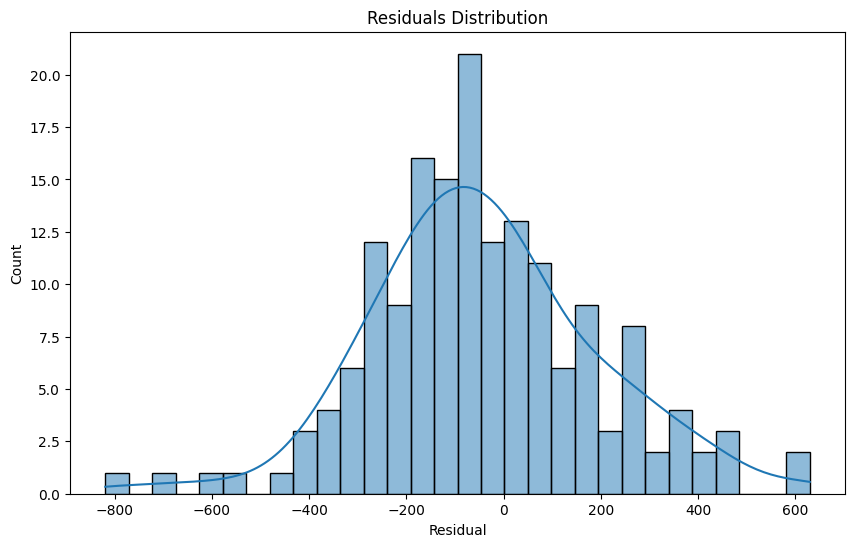

In [6]:
from sklearn.metrics import mean_squared_error

# Predict on the test set
y_pred = rf_final.predict(x_test)

# Scatter plot: Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residual')
plt.title('Residuals Distribution')
plt.show()

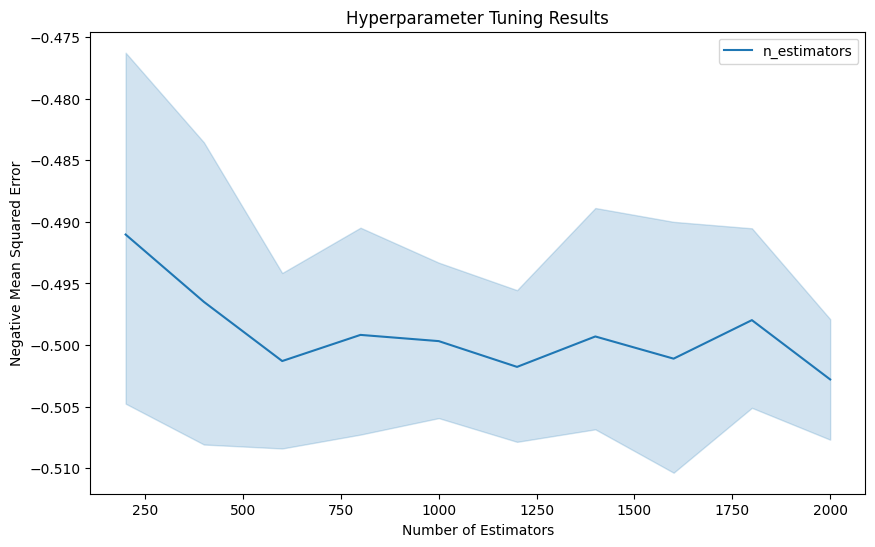

In [7]:
# Extract results from RandomizedSearchCV
results = pd.DataFrame(rf_random.cv_results_)

# Plotting hyperparameters vs. score
plt.figure(figsize=(10, 6))
sns.lineplot(x=results['param_n_estimators'], y=-results['mean_test_score'], label='n_estimators')
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative Mean Squared Error')
plt.legend()
plt.show()